Data Path: /content/loan_data_set.csv
Output Directory: results
Loading data...
Rows, cols: (614, 13)
Numeric cols: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical cols: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

=== TRAINING MODEL: lr ===
Best params: {'clf__C': 10}
OOF metrics: {'accuracy': 0.8061889250814332, 'f1': 0.873538788522848, 'roc_auc': np.float64(0.754369075829384), 'pr_auc': np.float64(0.8433833476901043), 'brier': np.float64(0.1565764080129584)}
ECE (OOF): 0.07851474492202655

=== TRAINING MODEL: rf ===
Best params: {'clf__max_depth': 12, 'clf__n_estimators': 200}
OOF metrics: {'accuracy': 0.7915309446254072, 'f1': 0.8626609442060086, 'roc_auc': np.float64(0.7445695102685623), 'pr_auc': np.float64(0.8312214673655626), 'brier': np.float64(0.1824942776646567)}
ECE (OOF): 0.14161193601321476

=== TRAINING MODEL: xgb ===
Best params: {'clf__learning_rate': 0.1, 'clf__m

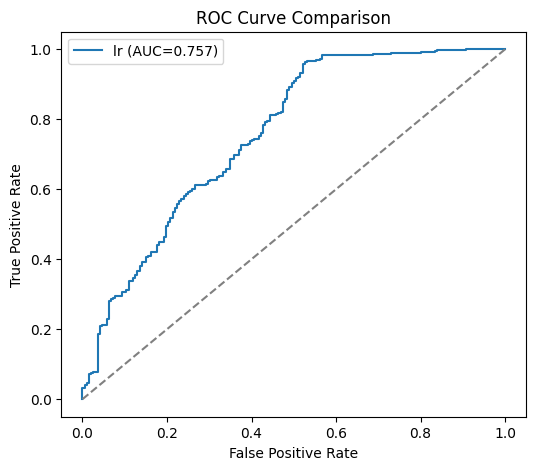

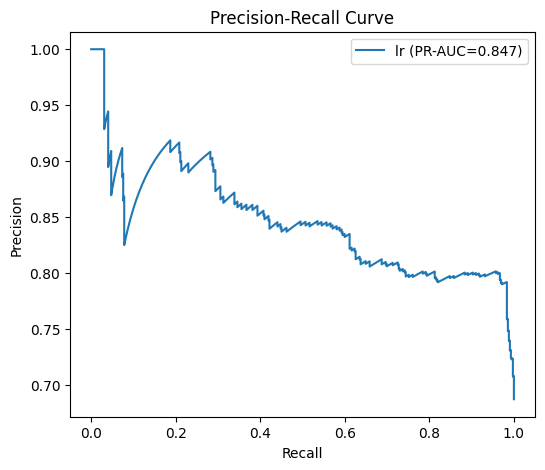

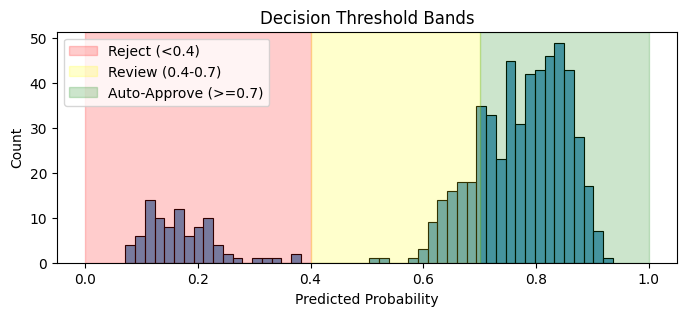

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score,
    precision_recall_curve, roc_curve, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from pathlib import Path

ROOT = Path(".")
DATA_PATH = Path("/content/loan_data_set.csv")
OUT_DIR = ROOT / "results"
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42

print(f"Data Path: {DATA_PATH}")
print(f"Output Directory: {OUT_DIR}")

# -------------- Helpers --------------
def load_data(path):
    df = pd.read_csv(path)
    return df

def iqr_trim(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lo = q1 - k*iqr
    hi = q3 + k*iqr
    return series.clip(lower=lo, upper=hi)

def evaluate_preds(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob >= thresh).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob)
    }

def expected_calibration_error(y_true, y_prob, n_bins=10):
    # Generate `n_bins` equally sized bins
    bin_edges = np.linspace(0., 1., n_bins + 1)
    # Assign each prediction to a bin
    bin_idx = np.digitize(y_prob, bin_edges) - 1 # -1 for 0-indexing to match array indices

    # Handle edge cases for probabilities exactly 0 or 1
    # Probabilities of 1.0 would fall into bin_idx == n_bins, so map to last bin
    bin_idx[bin_idx == n_bins] = n_bins - 1
    # Probabilities of 0.0 might fall into bin_idx < 0 if bin_edges starts > 0, so map to first bin
    bin_idx[bin_idx < 0] = 0

    # Calculate observed frequencies and mean predicted probabilities for each bin
    prob_true_per_bin = np.zeros(n_bins)
    prob_pred_per_bin = np.zeros(n_bins)
    counts_per_bin = np.zeros(n_bins)

    for i in range(n_bins):
        mask = (bin_idx == i)
        if np.any(mask):
            prob_true_per_bin[i] = y_true[mask].mean()
            prob_pred_per_bin[i] = y_prob[mask].mean()
            counts_per_bin[i] = np.sum(mask)

    # Filter out empty bins for ECE calculation
    non_empty_bins_mask = counts_per_bin > 0
    prob_true_filtered = prob_true_per_bin[non_empty_bins_mask]
    prob_pred_filtered = prob_pred_per_bin[non_empty_bins_mask]
    counts_filtered = counts_per_bin[non_empty_bins_mask]

    if np.sum(counts_filtered) == 0:
        return 0.0 # No samples in any non-empty bin to evaluate ECE

    # ECE: weighted average absolute difference
    ece = np.sum(np.abs(prob_true_filtered - prob_pred_filtered) * counts_filtered) / np.sum(counts_filtered)
    return float(ece)

# -------------- Load & quick EDA --------------
print("Loading data...")
df = load_data(DATA_PATH)
print("Rows, cols:", df.shape)
df.head()

# Assume target column name is 'Disbursed' (1/0) per report
target = "Loan_Status"
if target not in df.columns:
    raise ValueError(f"Target '{target}' not found in data")

# Map target variable to numerical (0/1)
df[target] = df[target].map({'Y': 1, 'N': 0})

# Basic cleaning: trim heavy outliers for numeric columns ApplicantIncome and LoanAmount if present
for col in ["ApplicantIncome", "LoanAmount"]:
    if col in df.columns:
        df[col] = iqr_trim(df[col])

# List feature types
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)
categorical_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# -------------- Column transformer & pipelines --------------
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", Pipeline([("impute", num_imputer), ("scale", scaler)]), numeric_cols),
    ("cat", Pipeline([("impute", cat_imputer), ("ohe", ohe)]), categorical_cols),
], remainder='drop')

# Models and parameter grids (kept modest for speed)
models = {
    "lr": (LogisticRegression(max_iter=1000, random_state=RANDOM_STATE), {
        "clf__C": [0.01, 0.1, 1, 10]
    }),
    "rf": (RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE), {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [6, 12]
    }),
    "xgb": (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE), {
        "clf__n_estimators": [100, 200],
        "clf__max_depth": [3, 6],
        "clf__learning_rate": [0.01, 0.1]
    })
}

# Stratified 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

X = df.drop(columns=[target])
y = df[target].astype(int).values

# We'll store fold-level predictions for each model
results = {}

for name, (estimator, param_grid) in models.items():
    print("\n=== TRAINING MODEL:", name, "===")
    # Create pipeline: preprocessor -> SMOTE (on train within CV) -> classifier
    # Use imblearn pipeline so SMOTE is applied only to training fold during cross_val
    pipe = ImbPipeline(steps=[
        ("preproc", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", estimator)
    ])

    # GridSearch on each training fold: use GridSearchCV with inner CV? To keep reproducible and similar to report,
    # perform GridSearchCV with 3-fold within train folds (this code uses GridSearchCV directly).
    gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring="roc_auc", n_jobs=-1, verbose=0)
    # Fit on all data but GridSearch will internally do CV. However to replicate stratified CV evaluation, we'll
    # produce out-of-fold predicted probabilities using cross_val_predict with the best estimator retrained on each fold.
    gs.fit(X, y)
    print("Best params:", gs.best_params_)
    best = gs.best_estimator_

    # Out-of-fold probabilities for honest performance (train-time + CV)
    oof_probs = cross_val_predict(best, X, y, cv=skf, method="predict_proba", n_jobs=-1)[:, 1]
    oof_metrics = evaluate_preds(y, oof_probs)
    ece = expected_calibration_error(y, oof_probs, n_bins=10)
    print("OOF metrics:", oof_metrics)
    print("ECE (OOF):", ece)

    # Fit final on full data (for SHAP / deployment)
    best.fit(X, y)
    results[name] = {
        "model": best,
        "oof_probs": oof_probs,
        "oof_metrics": oof_metrics,
        "ece": ece
    }

    # Save model
    joblib.dump(best, OUT_DIR / f"{name}_model.joblib")

# -------------- Compare & pick best (based on roc_auc) --------------
summary = []
for k, v in results.items():
    summary.append((k, v["oof_metrics"]["roc_auc"], v["oof_metrics"]["accuracy"], v["oof_metrics"]["f1"], v["ece"]))
summary_df = pd.DataFrame(summary, columns=["model","roc_auc","accuracy","f1","ece"]).sort_values("roc_auc", ascending=False)
print("\nSummary:\n", summary_df)
summary_df.to_csv(OUT_DIR / "model_summary.csv", index=False)

best_name = summary_df.iloc[0]["model"]
best_model = results[best_name]["model"]
print("Selected model:", best_name)

# -------------- Calibration on selected model --------------
print("Calibrating best model with Platt (sigmoid)...")
calibrator = CalibratedClassifierCV(estimator=best_model, method="sigmoid", cv=3)
calibrator.fit(X, y)
# OOF probs after calibration (cross_val_predict to be honest)
cal_oof = cross_val_predict(calibrator, X, y, cv=skf, method="predict_proba", n_jobs=-1)[:,1]
cal_metrics = evaluate_preds(y, cal_oof)
cal_ece = expected_calibration_error(y, cal_oof, n_bins=10)
print("Calibrated OOF metrics:", cal_metrics)
print("Calibrated ECE:", cal_ece)
joblib.dump(calibrator, OUT_DIR / f"{best_name}_calibrated.joblib")

# Plot ROC and PR curves (OOF)
fpr, tpr, _ = roc_curve(y, cal_oof)
precision, recall, _ = precision_recall_curve(y, cal_oof)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{best_name} (AUC={roc_auc_score(y, cal_oof):.3f})")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve Comparison")
plt.legend()
plt.savefig(OUT_DIR / "roc_curve.png", bbox_inches="tight")

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"{best_name} (PR-AUC={average_precision_score(y, cal_oof):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig(OUT_DIR / "pr_curve.png", bbox_inches="tight")

# -------------- SHAP explainability --------------
print("Running SHAP on sample (may take time)...")
# Prepare matrix through preprocessor pipeline (without SMOTE)
# We need preprocessed feature matrix: apply preproc.transform to X
preproc = best_model.named_steps['preproc']
X_pre = preproc.transform(X)  # numeric + one-hot encoded
# Create feature names
num_names = numeric_cols
cat_names = preproc.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(categorical_cols).tolist()
feat_names = num_names + cat_names
X_pre_df = pd.DataFrame(X_pre, columns=feat_names)

# For tree models, use TreeExplainer, else KernelExplainer (slow).
# Use LinearExplainer for Logistic Regression or TreeExplainer for tree-based models.
model_clf = best_model.named_steps['clf']
if isinstance(model_clf, (RandomForestClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(model_clf)
    shap_values = explainer.shap_values(X_pre_df)
elif isinstance(model_clf, LogisticRegression):
    explainer = shap.LinearExplainer(model_clf, X_pre_df)
    shap_values = explainer.shap_values(X_pre_df)
else:
    # Fallback to KernelExplainer for other types of models if needed (can be slow)
    explainer = shap.KernelExplainer(model_clf.predict_proba, X_pre_df)
    shap_values = explainer.shap_values(X_pre_df)

# Summary plot (mean absolute SHAP value)
plt.figure(figsize=(6,6))
shap.summary_plot(shap_values, X_pre_df, show=False, plot_size=(6,6))
plt.savefig(OUT_DIR / "shap_summary.png", bbox_inches="tight", dpi=150)
plt.close()

# -------------- Fairness checks (AUC & approval rates by group) --------------
print("Fairness checks by Gender and PropertyArea (if present)...")
def group_metrics(df, group_col, y_true, probs):
    rows = []
    for g, idx in df.groupby(group_col).groups.items():
        mask = df.index.isin(idx)
        if mask.sum() < 10: continue
        auc = roc_auc_score(y_true[mask], probs[mask])
        appr_rate = (probs[mask] >= 0.5).mean()
        rows.append({"group": g, "auc": auc, "approval_rate": appr_rate, "n": mask.sum()})
    return pd.DataFrame(rows)

metadata = X.copy()
metadata["__y"] = y
metadata["__prob"] = cal_oof
if "Gender" in metadata.columns:
    gender_df = group_metrics(metadata, "Gender", metadata["__y"].values, metadata["__prob"].values)
    print("Gender fairness:\n", gender_df)
    gender_df.to_csv(OUT_DIR / "fairness_gender.csv", index=False)

if "PropertyArea" in metadata.columns:
    prop_df = group_metrics(metadata, "PropertyArea", metadata["__y"].values, metadata["__prob"].values)
    print("PropertyArea fairness:\n", prop_df)
    prop_df.to_csv(OUT_DIR / "fairness_propertyarea.csv", index=False)

# -------------- Threshold optimization (cost-aware) --------------
# Simple cost model: loss_fp = average loss when we approve a bad loan, loss_fn = opportunity cost when rejecting a good loan
loss_fp = 5000.0   # example: expected monetary loss for false approval
loss_fn = 100.0    # example: missed revenue/opportunity when incorrectly rejecting good applicant
probs = cal_oof
thS = np.linspace(0.0, 1.0, 201)
profits = []
for t in thS:
    preds = (probs >= t).astype(int)
    fp = ((preds == 1) & (y == 0)).sum()
    fn = ((preds == 0) & (y == 1)).sum()
    # profit (negative loss)
    profit = -(fp * loss_fp + fn * loss_fn)
    profits.append(profit)
best_idx = int(np.argmax(profits))
best_thresh = thS[best_idx]
print("Profit maximizing threshold (example costs):", best_thresh, "profit:", profits[best_idx])

# If you'd rather use the report's example, they found ~0.42
suggested_thresh = 0.42

# Create decision bands per report: Reject (<0.4), Review (0.4-0.7), Auto-Approve (>=0.7)
def decision_band(p):
    if p < 0.4: return "Reject"
    if p < 0.7: return "Review"
    return "Auto-Approve"

decisions = [decision_band(p) for p in probs]
pd.Series(decisions).value_counts().to_csv(OUT_DIR / "decision_band_counts.csv")

# Plot threshold bands on predicted probability histogram
plt.figure(figsize=(8,3))
sns.histplot(probs, bins=50)
plt.axvspan(0.0, 0.4, color='red', alpha=0.2, label='Reject (<0.4)')
plt.axvspan(0.4, 0.7, color='yellow', alpha=0.2, label='Review (0.4-0.7)')
plt.axvspan(0.7, 1.0, color='green', alpha=0.2, label='Auto-Approve (>=0.7)')
plt.legend()
plt.xlabel("Predicted Probability")
plt.title("Decision Threshold Bands")
plt.savefig(OUT_DIR / "decision_threshold_bands.png", bbox_inches="tight")

print("All artifacts written to:", OUT_DIR.resolve())